# Phase 2 Project
### Predicting house prices in King County using linear regression
#### Group:
* Brett Zimmerman
* Eddie Lin
* Jax Garnett
* Tony Bai

## Business Problem
Our real estate holding group startup Detova Veda is making a pitch to help smaller investors compete against established real estate investment firms. In order to show that we can help clients in their venture, we must show that our product can accurately predict how well an upgrade in any aspect of a home will impact its sale price. This predictive model will use these small investors to infiltrate the real estate investment market. To provide an answer, we looked into the question: what is the most impactful way you can increase the value of a home?

This is an important question, because real estate is a high stakes industry. Investors will want a direction to go where they can be confident they will get a return on their investment. Therefore, we must provide a concrete answer for them.

In [1]:
# import all libraries etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import warnings

# !pip install uszipcode #already installed run this if you run into an error 

## Business Understanding
For the sake of this project we will be acting as a consulting firm helping individual investors assess renovations and recommend going through with rennovations based on expected increase in value after those improvements

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")


# explore the data
data= pd.read_csv("data/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,nan,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

###  The data needs some cleaning. Many col are objects which will trigger the model

* Cleaned the basement information where "?" were converted to nan
* Waterfront Col replaced nan with 0
* view nans were changed into 0

In [4]:
#cleaning 

#sqft basement was c
sqft_basement_list= []
for num in data['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))
data['sqft_basement']= sqft_basement_list
#cleaning year renovated        
data['yr_renovated'] = data['yr_renovated'].fillna(0).astype(int)
data['yr_renovated'] = np.where(data['yr_renovated'] == 0, data['yr_built'], data['yr_renovated'])


#waterfron cleaning
data['waterfront'].replace(np.nan, 0, inplace =True)
#view col cleaning
data['view'].replace(np.nan, 0 , inplace =True)

#basement
data['sqft_basement'].fillna(0, inplace= True)

#drop not useful cols such as ID, Date
data.drop(['id', 'date'],1, inplace= True)

#one house has a 33 bedroom house to 3:
data['bedrooms'].replace(33, 3, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  int64  
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

# 1) Baseline Model

In [6]:
from sklearn.dummy import DummyRegressor
X = data.drop(['price'],1)
y = data['price']

In [7]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
dummy_regr.predict(X)

#here is our baseline model

mean_baseline = dummy_regr.predict(X)[0]

dummy_regr.score(X, y)
mean_baseline

540296.5735055795

### lets explore the correlation of these given variables and how it compares to our target variable ~ Price

In [8]:
data.corr()['price']

price            1.00
bedrooms         0.32
bathrooms        0.53
sqft_living      0.70
sqft_lot         0.09
floors           0.26
waterfront       0.26
view             0.39
condition        0.04
grade            0.67
sqft_above       0.61
sqft_basement    0.32
yr_built         0.05
yr_renovated     0.10
zipcode         -0.05
lat              0.31
long             0.02
sqft_living15    0.59
sqft_lot15       0.08
Name: price, dtype: float64

## Simple model
#### We decided to built a simple model by selecting all features above .5

In [9]:
# for loop to get select the features
selected=[]
index= 0
for f in data.corr()['price']:
    if f > .5:
        selected.append(data.corr().index[index])
        index +=1
    


In [10]:
# select the dataframe with the selected features from the correlation

df_simple= data[selected]

df_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1012.5 KB


In [11]:
#dropping price column to initiate the model

X= df_simple.drop('price', 1)
y= df_simple['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5106469795956301
0.507968464669422


In [13]:
model_simple = sm.OLS(y, sm.add_constant(X)).fit()
model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     4499.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:53:07   Log-Likelihood:            -2.9968e+05
No. Observations:               21597   AIC:                         5.994e+05
Df Residuals:                   21591   BIC:                         5.994e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.321e+04   7833.693     11.898      0.000    7.79e+04    1.09e+05
bedrooms    -6.574e+04   2453.097    -26.799      0.000   -7.05e+04   -6.09e+04
bathrooms    7971.0714   3825.214      2.084      0.037     473.369    1.55e+04
sqft_living   317.7052      3.158    100.618      0.000     311.516     323.894
sqft_lot       -0.3894      0.043     -9.013      0.000      -0.474      -0.305
floors      -2113.7354   3780.123     -0.559      0.576   -9523.056    5295.585
==============================================================================
Omnibus:                    14192.774   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           466811.285
Skew:                           2.682   Prob(JB):                         0.00
Kurtosis:                      25.135   Cond. No.                     2.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Lets try to use a RFE and see what kind of simple model we can create!

In [14]:
#we will choose the top 3

lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=3)

select.fit(X=data.drop(['price'], 1), y=y)

select.support_

# from the boolean array we can see that waterfront, grade and lat were chosen

array([False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False,  True, False, False, False])

In [15]:
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650
1,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509
21593,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200
21594,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007
21595,400000.00,3,2.50,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287


In [16]:
#lets run another simple model

selected_2=['price', "waterfront", 'lat', 'grade']

df_simple2 = data[selected_2]


In [17]:
df_simple2

,price,waterfront,lat,grade
0,221900.00,0.00,47.51,7
1,538000.00,0.00,47.72,7
2,180000.00,0.00,47.74,6
3,604000.00,0.00,47.52,7
4,510000.00,0.00,47.62,8
...,...,...,...,...
21592,360000.00,0.00,47.70,8
21593,400000.00,0.00,47.51,8
21594,402101.00,0.00,47.59,7
21595,400000.00,0.00,47.53,8


In [18]:
y2=df_simple2['price']
X2= df_simple2.drop('price',1)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=22)


lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5428183986058313
0.559834832660635


In [19]:
#running another model

model_simple = sm.OLS(y2, sm.add_constant(X2)).fit()
model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     8666.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:53:08   Log-Likelihood:            -2.9886e+05
No. Observations:               21597   AIC:                         5.977e+05
Df Residuals:                   21593   BIC:                         5.978e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.104e+07   5.81e+05    -53.450      0.000   -3.22e+07   -2.99e+07
waterfront  9.666e+05   2.06e+04     46.864      0.000    9.26e+05    1.01e+06
lat         6.325e+05   1.22e+04     51.693      0.000    6.09e+05    6.57e+05
grade       1.951e+05   1449.939    134.545      0.000    1.92e+05    1.98e+05
==============================================================================
Omnibus:                    20496.293   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2636697.886
Skew:                           4.218   Prob(JB):                         0.00
Kurtosis:                      56.469   Cond. No.                     1.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Our simple models have a score R^2 is .509 (based on highest correlation to target var) and .0546 (RFE selection) , lets see if we can improve on that
#### We will try by using:
* **Feature engineering**
* **Dummy Variables**


In [20]:
# first we will engineer a feature to see wether the entry belongs in a top 25 zipcode by mean price

zip_code = data.groupby("zipcode")["price"].mean().sort_values(ascending = False)
zip_code.describe()

count        70.00
mean     561010.93
std      302394.02
min      234284.04
25%      354133.94
50%      492001.21
75%      645532.23
max     2161300.00
Name: price, dtype: float64

In [21]:
# since there are 70 zipcodes included we will look to include top 25
top_20 = data.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:20]
top_20

zipcode
98039   2161300.00
98004   1356523.99
98040   1194873.64
98112   1096239.01
98102    899607.67
98109    880077.75
98105    863228.94
98006    859938.55
98119    849714.81
98005    810289.70
98033    803990.82
98199    792187.87
98075    790734.70
98074    685675.84
98077    682885.99
98053    677215.03
98177    676419.39
98008    645628.23
98052    645244.23
98122    634558.14
Name: price, dtype: float64

In [22]:
#start out with a fresh new dataframe using the initial
df_complex = data

df_complex

# set an index for the top 20 zipcodes
zipcode_index = top_20.index

#covert a col of booleans into 0 or 1 (tells us where the house is in a top 20 neighborhood)
df_complex['top20_neighborhood'] = data['zipcode'].isin(zipcode_index).astype(int)

In [23]:
df_complex

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,top20_neighborhood
0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,0
1,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,0
2,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,0
3,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,0
4,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509,0
21593,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,0
21594,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,0
21595,400000.00,3,2.50,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,0


## Lets make this model more complex! We will deal with categorical variables


In [24]:
#Dummying grade
grade_origin= data['grade']
df_dummy_grade= pd.get_dummies(grade_origin, drop_first= True) #avoid dummy trap
df_complex = pd.concat([df_dummy_grade, df_complex], axis=1)

#renaming the new Columns
#grade
mapper = {4:'Grade_4', 5: 'Grade_5', 6:'Grade_6',7:'Grade_7',
          8:'Grade_8',9:'Grade_9',10:'Grade_10', 11:'Grade_11',12:'Grade_12',13:'Grade_13'} 
df_complex.rename(mapper=mapper, axis=1, inplace= True)

In [25]:
#making dummy for condition
condition_origin= data['condition']
df_cond_dum=pd.get_dummies(condition_origin, drop_first=True)
df_complex= pd.concat([df_cond_dum, df_complex], axis=1)

mapper3 = {1:'Condition_1',2:'Condition_2',3:'Condition_3',4:'Condition_4',5:'Condition_5'}
df_complex.rename(mapper=mapper3, axis=1, inplace=True)

In [26]:
#Dummying the view
view_origin= data['view']
df_dummy_view= pd.get_dummies(view_origin, drop_first= True)
df_complex = pd.concat([df_dummy_view, df_complex], axis=1)

#renaming the new Columns
#view

mapper_view = {4.0:'View 4', 2.0: 'View 2', 3.0:'View 3',1.0:'View 1'}

df_complex.rename(mapper=mapper_view, axis=1, inplace= True)

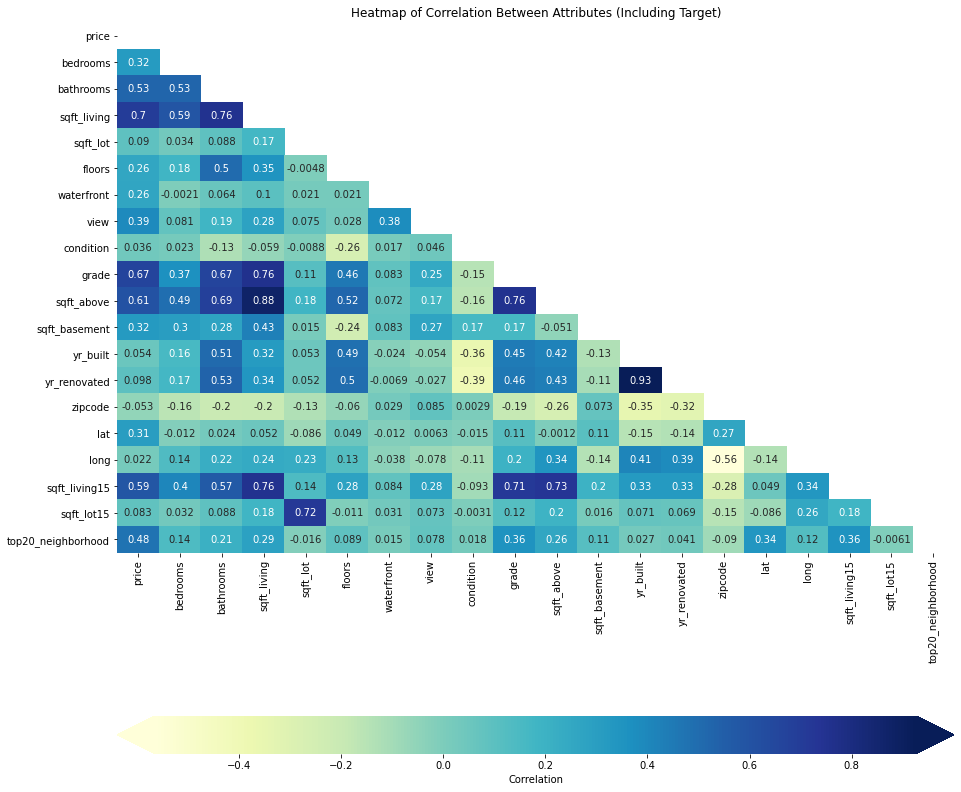

In [27]:
corr = data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    data=corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),    
    ax=ax,
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"},
    cmap="YlGnBu"
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [28]:
"""looking at the heat map we wanted to engineer some 
features together to get rid of colinearity that could arise from our complex model"""

'looking at the heat map we wanted to engineer some \nfeatures together to get rid of colinearity that could arise from our complex model'

In [29]:
# adding some interactions
df_complex['age'] = 2021 - df_complex['yr_built']

#decided to combine Bath and Bedroom into a ratio (Bed:Bath) since its a commonly used metric fpr real estate

df_complex['bed:bath'] = df_complex['bedrooms']/df_complex['bathrooms']

df_complex = df_complex.loc[:,~df_complex.columns.duplicated()]

In [30]:
df_complex

,View 1,View 2,View 3,View 4,Condition_2,Condition_3,Condition_4,Condition_5,Grade_4,Grade_5,Grade_6,Grade_7,Grade_8,Grade_9,Grade_10,Grade_11,Grade_12,Grade_13,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,top20_neighborhood,age,bed:bath
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,221900.00,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,0,66,3.00
1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,0,70,1.33
2,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,0,88,2.00
3,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.00,1965,1965,98136,47.52,-122.39,1360,5000,0,56,1.33
4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.00,1987,1987,98074,47.62,-122.05,1800,7503,1,34,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,3,8,1530,0.00,2009,2009,98103,47.70,-122.35,1530,1509,0,12,1.20
21593,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,3,8,2310,0.00,2014,2014,98146,47.51,-122.36,1830,7200,0,7,1.60
21594,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,3,7,1020,0.00,2009,2009,98144,47.59,-122.30,1020,2007,0,12,2.67
21595,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,400000.00,3,2.50,1600,2388,2.00,0.00,0.00,3,8,1600,0.00,2004,2004,98027,47.53,-122.07,1410,1287,0,17,1.20


In [31]:
# drop the original col that were used to dummy and those used for feature engineering

df_complex.drop(['view', 'grade', 'bedrooms', 'bathrooms', 'condition', 'yr_renovated'], axis=1, inplace=True)

In [32]:
# conduct another test 

y3 = df_complex['price']
X3 = df_complex.drop('price',1)


X_train, X_test, y_train, y_test = train_test_split(X3, y2, test_size=0.2, random_state=22)


model_complex = sm.OLS(y2, sm.add_constant(X3)).fit()
model_complex.summary()


lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.7548850185789532
0.7441797105243229


In [33]:


y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)


train_mse = mean_squared_error(y_train, y_hat_train, squared =False)
test_mse = mean_squared_error(y_test, y_hat_test, squared=False)
print('Train Mean Error:', train_mse)
print('Test Mean Error:', test_mse)

Train Mean Error: 181641.95660216658
Test Mean Error: 186756.58062198097


In [34]:
model_complex = sm.OLS(y2, sm.add_constant(X3)).fit()
model_complex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     2061.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:53:09   Log-Likelihood:            -2.9226e+05
No. Observations:               21597   AIC:                         5.846e+05
Df Residuals:                   21564   BIC:                         5.849e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.5112      1.301     -0.393      0.694      -3.061       2.038
View 1              1.214e+05   1.03e+04     11.803      0.000    1.01e+05    1.42e+05
View 2              7.794e+04   6252.025     12.466      0.000    6.57e+04    9.02e+04
View 3              1.518e+05   8561.474     17.732      0.000    1.35e+05    1.69e+05
View 4              2.815e+05   1.29e+04     21.779      0.000    2.56e+05    3.07e+05
Condition_2         7.824e+04   3.68e+04      2.126      0.034    6102.752     1.5e+05
Condition_3         9.469e+04   3.42e+04      2.766      0.006    2.76e+04    1.62e+05
Condition_4         1.108e+05   3.42e+04      3.236      0.001    4.37e+04    1.78e+05
Condition_5         1.572e+05   3.44e+04      4.566      0.000    8.97e+04    2.25e+05
Grade_4            -1.393e+05   1.86e+05     -0.749      0.454   -5.04e+05    2.25e+05
Grade_5            -1.587e+05   1.83e+05     -0.868      0.386   -5.17e+05       2e+05
Grade_6            -1.431e+05   1.83e+05     -0.783      0.433   -5.01e+05    2.15e+05
Grade_7            -1.124e+05   1.83e+05     -0.615      0.538    -4.7e+05    2.46e+05
Grade_8             -7.09e+04   1.83e+05     -0.388      0.698   -4.29e+05    2.87e+05
Grade_9             3.093e+04   1.83e+05      0.169      0.866   -3.27e+05    3.89e+05
Grade_10            1.757e+05   1.83e+05      0.961      0.337   -1.83e+05    5.34e+05
Grade_11            4.275e+05   1.83e+05      2.334      0.020    6.85e+04    7.86e+05
Grade_12             8.81e+05   1.84e+05      4.785      0.000     5.2e+05    1.24e+06
Grade_13            2.069e+06    1.9e+05     10.873      0.000     1.7e+06    2.44e+06
sqft_living          120.3669     16.233      7.415      0.000      88.549     152.185
sqft_lot               0.1939      0.044      4.455      0.000       0.109       0.279
floors              3.874e+04   3251.957     11.914      0.000    3.24e+04    4.51e+04
waterfront          5.586e+05   1.85e+04     30.194      0.000    5.22e+05    5.95e+05
sqft_above            25.7363     16.403      1.569      0.117      -6.415      57.888
sqft_basement         23.8129     16.245      1.466      0.143      -8.029      55.655
yr_built           -1469.7933   1304.268     -1.127      0.260   -4026.255    1086.669
zipcode             -501.3068     30.148    -16.628      0.000    -560.399    -442.214
lat                 4.575e+05   1.03e+04     44.467      0.000    4.37e+05    4.78e+05
long               -2.487e+05    1.2e+04    -20.736      0.000   -2.72e+05   -2.25e+05
sqft_living15          2.8139      3.188      0.883      0.377      -3.435       9.063
sqft_lot15            -0.2754      0.066     -4.143      0.000      -0.406      -0.145
top20_neighborhood  1.581e+05   3313.577     47.723      0.000    1.52e+05    1.65e+05
age                  436.6997   1325.1

## Our complex model performed much better with an R^2 of .752

In [35]:
# ok lets see if we can reduce error by removing some outliers

# lets look at our continous variables 

continuous = ["sqft_living", 'sqft_above', 'sqft_lot', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age']

## Lets explore relationship between features and target

## H0 =. Target and Features have a linear relationship

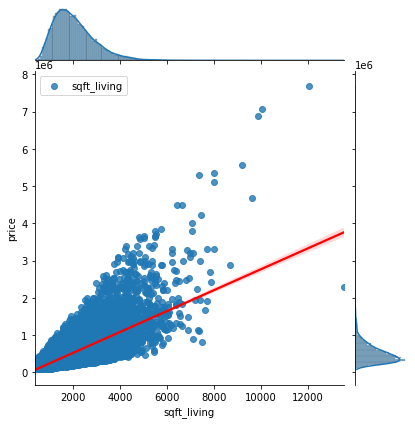

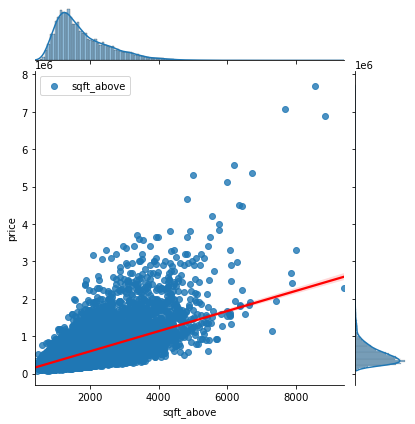

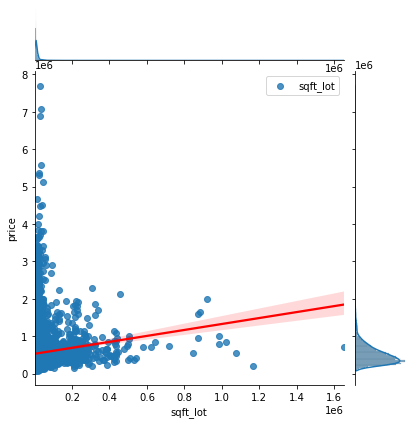

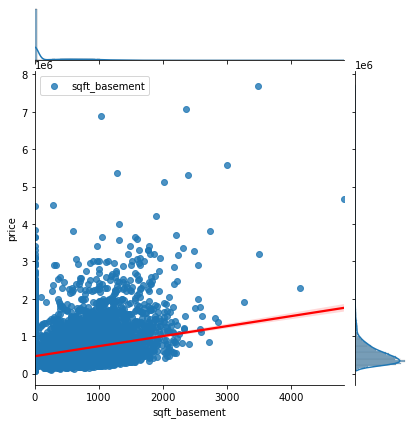

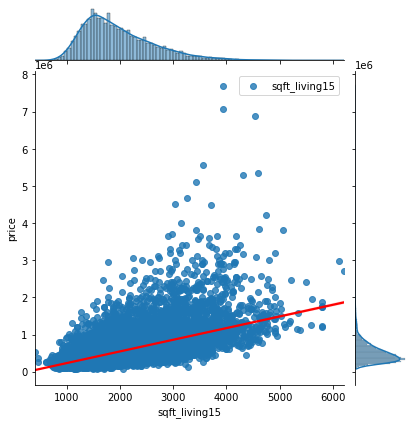

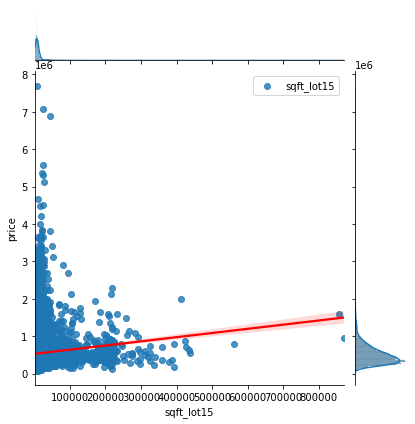

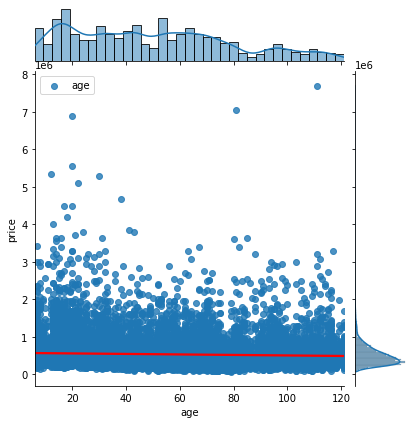

In [36]:

for column in continuous:
    sns.jointplot(x=column, y="price", data=df_complex, kind='reg', label=column,joint_kws={'line_kws':{'color':'red'}})
    plt.legend()
    plt.show()
    
    
#

## Looking at our continous variables it doesnt seem that the relationship between our target and predictor has a linear relationship. We can reject the Null
We think that the outliers are causing our model to be less accurate and underfit. Let's see what happens when we remove some of our outliers and some variables that have no linear relationship to the target variable.

From above we can see that sqft_lot15, sqft_lot and sqft_basement seems to be good choices to drop

### We also noticed that many of these continous variables have outliers with respect to the price so lets take a look at the distribution of price

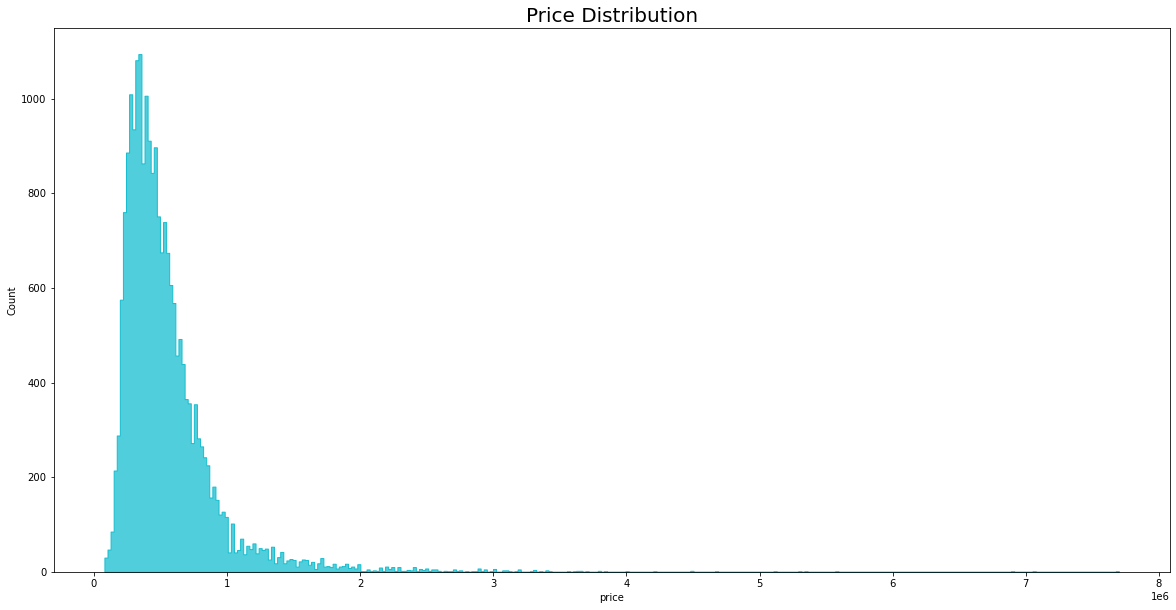

In [37]:
fig, ax = plt.subplots(figsize= (20,10))

ax.set_title('Price Distribution', fontsize= 20)
sns.histplot(df_complex, x=y2, element="step", legend=False, color = 'tab:cyan' );


In [38]:
# function that will outlier that are two standard deviations from our mean - 80

def rmv_outlier (df, param):
    i = 0
    drop_index = []
    for x in df[param]:
        if x > df[param].mean() + 2*df[param].std():
            drop_index.append(i)
        if x < df[param].mean() - 2*df[param].std():
            #if x<=1:
            #    pass
            drop_index.append(i)
        i+=1
    df.drop(df.index[drop_index], axis =0, inplace = True)
    return df.reset_index()

## Lets drop price outliers with our function

In [39]:
#before we drop the outliers we have 21597 inputs
df_complex.describe()

,View 1,View 2,View 3,View 4,Condition_2,Condition_3,Condition_4,Condition_5,Grade_4,Grade_5,Grade_6,Grade_7,Grade_8,Grade_9,Grade_10,Grade_11,Grade_12,Grade_13,price,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,top20_neighborhood,age,bed:bath
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,0.02,0.04,0.02,0.01,0.01,0.65,0.26,0.08,0.00,0.01,0.09,0.42,0.28,0.12,0.05,0.02,0.00,0.00,540296.57,2080.32,15099.41,1.49,0.01,1788.60,285.72,1971.00,98077.95,47.56,-122.21,1986.62,12758.28,0.27,50.00,1.75
std,0.12,0.21,0.15,0.12,0.09,0.48,0.44,0.27,0.04,0.11,0.29,0.49,0.45,0.33,0.22,0.13,0.06,0.02,367368.14,918.11,41412.64,0.54,0.08,827.76,439.82,29.38,53.51,0.14,0.14,685.23,27274.44,0.44,29.38,0.65
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,78000.00,370.00,520.00,1.00,0.00,370.00,0.00,1900.00,98001.00,47.16,-122.52,399.00,651.00,0.00,6.00,0.40
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,322000.00,1430.00,5040.00,1.00,0.00,1190.00,0.00,1951.00,98033.00,47.47,-122.33,1490.00,5100.00,0.00,24.00,1.33
50%,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,450000.00,1910.00,7618.00,1.50,0.00,1560.00,0.00,1975.00,98065.00,47.57,-122.23,1840.00,7620.00,0.00,46.00,1.60
75%,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,645000.00,2550.00,10685.00,2.00,0.00,2210.00,550.00,1997.00,98118.00,47.68,-122.12,2360.00,10083.00,1.00,70.00,2.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,7700000.00,13540.00,1651359.00,3.50,1.00,9410.00,4820.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00,1.00,121.00,8.00


In [40]:

#removes outliers 2 std out from our mean in the data set
rmv_outlier(df_complex,'price')

,index,View 1,View 2,View 3,View 4,Condition_2,Condition_3,Condition_4,Condition_5,Grade_4,Grade_5,Grade_6,Grade_7,Grade_8,Grade_9,Grade_10,Grade_11,Grade_12,Grade_13,price,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,top20_neighborhood,age,bed:bath
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,221900.00,1180,5650,1.00,0.00,1180,0.00,1955,98178,47.51,-122.26,1340,5650,0,66,3.00
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,538000.00,2570,7242,2.00,0.00,2170,400.00,1951,98125,47.72,-122.32,1690,7639,0,70,1.33
2,2,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,180000.00,770,10000,1.00,0.00,770,0.00,1933,98028,47.74,-122.23,2720,8062,0,88,2.00
3,3,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,604000.00,1960,5000,1.00,0.00,1050,910.00,1965,98136,47.52,-122.39,1360,5000,0,56,1.33
4,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,510000.00,1680,8080,1.00,0.00,1680,0.00,1987,98074,47.62,-122.05,1800,7503,1,34,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20751,21592,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,360000.00,1530,1131,3.00,0.00,1530,0.00,2009,98103,47.70,-122.35,1530,1509,0,12,1.20
20752,21593,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,400000.00,2310,5813,2.00,0.00,2310,0.00,2014,98146,47.51,-122.36,1830,7200,0,7,1.60
20753,21594,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,402101.00,1020,1350,2.00,0.00,1020,0.00,2009,98144,47.59,-122.30,1020,2007,0,12,2.67
20754,21595,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,400000.00,1600,2388,2.00,0.00,1600,0.00,2004,98027,47.53,-122.07,1410,1287,0,17,1.20


In [41]:
percent_data_removed=(21597-20756)/21597
percent_data_removed

0.038940593600963094

**Nice!!! We only removed 4% of our data! Lets now remove some collinear dependent variables from our model**

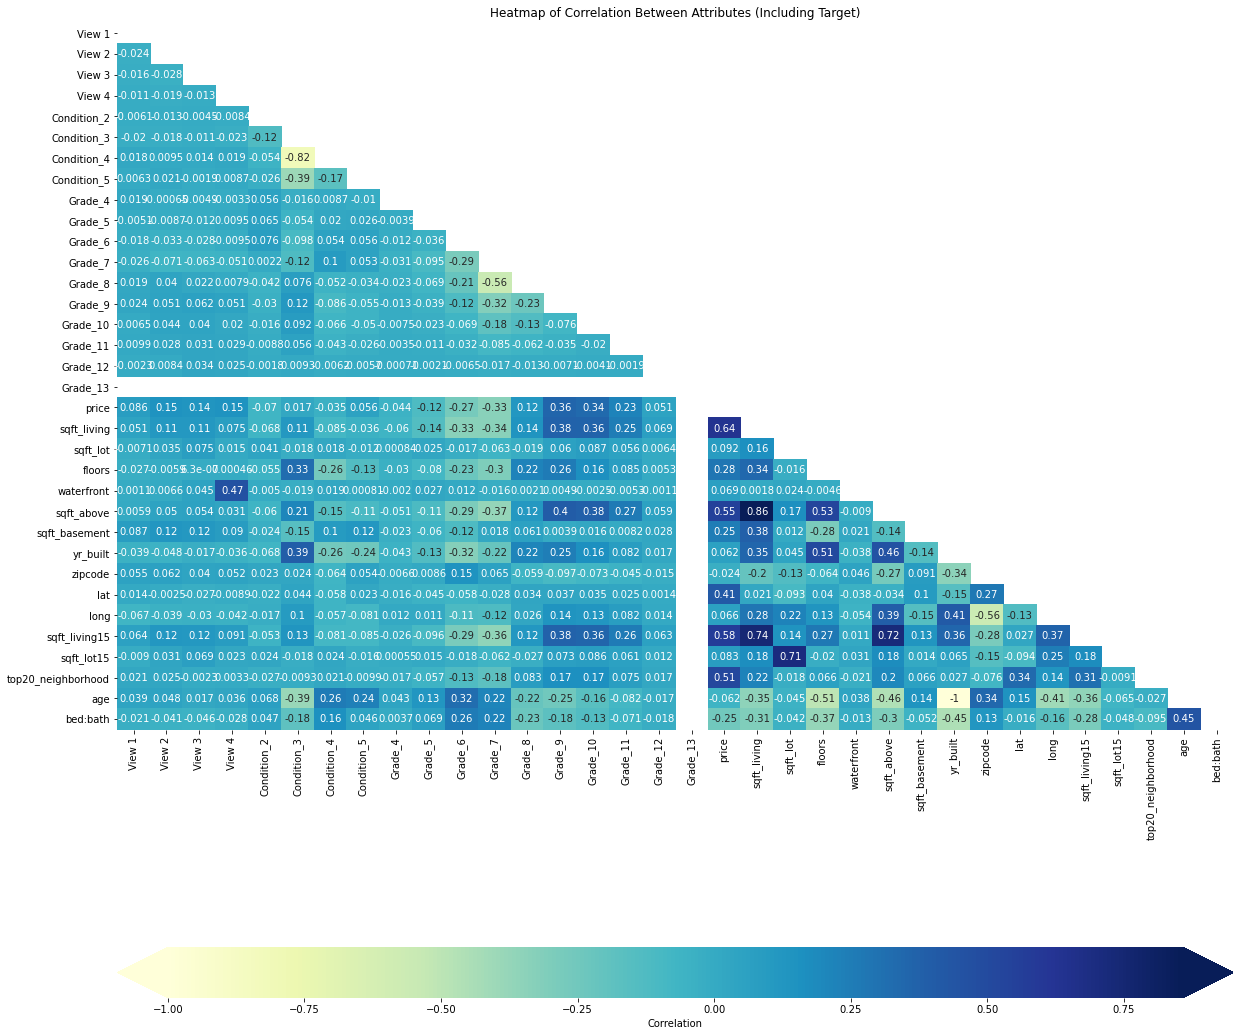

In [42]:
corr = df_complex.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"},
    cmap="YlGnBu"
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Looking at this heatmap : 
* we have decided to drop sqft_above due to the high correlation with sqft_living
* grade 13 since its null values
* yr_built since age is a feature engineered from it

In [43]:

df_complex_clean = df_complex.drop(['Grade_13', 'sqft_above', "yr_built"], axis=1)

# Let's test the new data

In [44]:


y4 = df_complex_clean['price']
X4 = df_complex_clean.drop('price',1)


X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.2, random_state=22)


model_complex_clean = sm.OLS(y4, sm.add_constant(X4)).fit()
model_complex_clean.summary()


lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.7460710388598212
0.7556287911887468


In [45]:
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train, squared =False)
test_mse = mean_squared_error(y_test, y_hat_test, squared=False)
print('Train Mean Error:', train_mse)
print('Test Mean Error:', test_mse)

Train Mean Error: 112433.22047929729
Test Mean Error: 113512.62727192108


In [46]:
# Cross Validate
scores_simple = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
scores_simple
display(np.mean(scores_simple['train_score']), np.std(scores_simple['train_score']))
np.mean(scores_simple['test_score']), np.std(scores_simple['test_score'])

0.7462936442929553

0.0030841922952304897

(0.7439429001010582, 0.0125700498532281)

## R2 was worse but the mean squared error decreased ! 

## Mean Error indicates that we are off by about 113k on each prediction

In [47]:

model_complex_clean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     2053.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:53:58   Log-Likelihood:            -2.7088e+05
No. Observations:               20756   AIC:                         5.418e+05
Df Residuals:                   20725   BIC:                         5.421e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.337e+07   1.66e+06     -8.035      0.000   -1.66e+07   -1.01e+07
View 1              7.616e+04   6804.471     11.193      0.000    6.28e+04    8.95e+04
View 2              6.709e+04   4083.762     16.429      0.000    5.91e+04    7.51e+04
View 3              1.037e+05   5981.141     17.345      0.000     9.2e+04    1.15e+05
View 4               1.77e+05   9776.227     18.106      0.000    1.58e+05    1.96e+05
Condition_2           7.3e+04   2.31e+04      3.161      0.002    2.77e+04    1.18e+05
Condition_3         1.014e+05   2.15e+04      4.711      0.000    5.92e+04    1.44e+05
Condition_4         1.176e+05   2.15e+04      5.462      0.000    7.54e+04     1.6e+05
Condition_5          1.57e+05   2.17e+04      7.250      0.000    1.15e+05    1.99e+05
Grade_4             -1.25e+05   1.15e+05     -1.088      0.276    -3.5e+05       1e+05
Grade_5            -1.212e+05   1.13e+05     -1.073      0.283   -3.43e+05       1e+05
Grade_6             -9.52e+04   1.13e+05     -0.844      0.399   -3.16e+05    1.26e+05
Grade_7            -4.281e+04   1.13e+05     -0.379      0.704   -2.64e+05    1.78e+05
Grade_8             1.723e+04   1.13e+05      0.153      0.879   -2.04e+05    2.38e+05
Grade_9             1.109e+05   1.13e+05      0.982      0.326    -1.1e+05    3.32e+05
Grade_10            1.749e+05   1.13e+05      1.548      0.122   -4.65e+04    3.96e+05
Grade_11            2.507e+05   1.13e+05      2.213      0.027    2.87e+04    4.73e+05
Grade_12            2.164e+05    1.2e+05      1.805      0.071   -1.85e+04    4.51e+05
sqft_living           85.4715      1.997     42.797      0.000      81.557      89.386
sqft_lot               0.2536      0.028      9.051      0.000       0.199       0.309
floors              4.106e+04   2062.593     19.909      0.000     3.7e+04    4.51e+04
waterfront          1.485e+05   1.63e+04      9.115      0.000    1.17e+05     1.8e+05
sqft_basement          3.9754      2.635      1.509      0.131      -1.190       9.141
zipcode             -214.8451     19.059    -11.272      0.000    -252.203    -177.487
lat                 4.388e+05   6411.186     68.448      0.000    4.26e+05    4.51e+05
long                -1.11e+05   7527.865    -14.747      0.000   -1.26e+05   -9.63e+04
sqft_living15         27.3622      2.132     12.833      0.000      23.183      31.542
sqft_lot15            -0.0962      0.043     -2.258      0.024      -0.180      -0.013
top20_neighborhood  1.196e+05   2101.372     56.895      0.000    1.15e+05    1.24e+05
age                 1656.2155     40.530     40.864      0.000    1576.773    1735.658
bed:bath           -1.629e+04   1414.598    -11.519      0.000   -1.91e+04   -1.35e+04
==============================================================================
Omnibus:                     2232.967   Durbin

### Investigating error distribution with QQ plot

In [48]:
## Errors seem to be normally distributed given our data set after removing some outliers

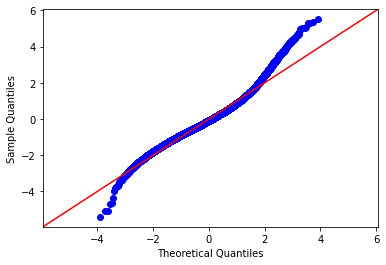

In [49]:
residuals = model_complex_clean.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### Let's check for linearity of the Residuals

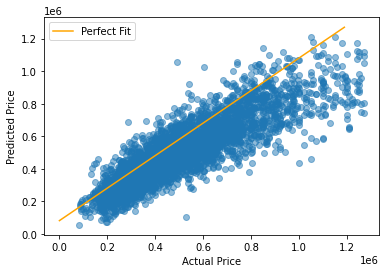

In [50]:
#Graphing the residuals

y_fit = df_complex_clean['price']
X_fit = df_complex_clean.drop('price',1)
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(X4, y4, test_size=0.2, random_state=22)
model_complex_clean2 = sm.OLS(y_fit,X_fit).fit()
preds_2 = model_complex_clean2.predict(np.squeeze(np.asarray(X_test_graph)))
fig, ax = plt.subplots()
perfect_line = np.arange(y_test_graph.min(), y_test_graph.max())
ax.plot(perfect_line, color="orange", label="Perfect Fit")
ax.scatter(y_test_graph, preds_2, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

### This graph shows a generally homoscedastic residuals, we have a outliers and a slightly conic shape but for the sake of this project we are satisfactory 

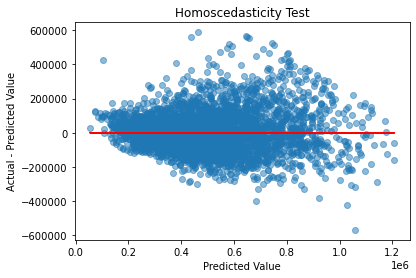

In [51]:
fig2, ax2 = plt.subplots()
residuals3 = (y_test_graph - preds_2)
ax2.scatter(preds_2, residuals3, alpha=0.5)
ax2.plot(preds_2, [0 for i in range(len(X_test_graph))],color= 'red')
ax2.set_xlabel("Predicted Value")
ax2.set_ylabel("Actual - Predicted Value")
ax2.set_title("Homoscedasticity Test");

The residuals look somewhat linear, for the limitations of this project we are satisfied with these results and assume that our residuals are not violating linearity

## What if we made a even more complex model with interactions!


In [52]:
df_test22= data.drop('price',1)

In [53]:
df_new=df_test22.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_new['pairs'] = list(zip(df_new.level_0, df_new.level_1))
df_new.set_index(['pairs'], inplace = True)
df_new.drop(columns=['level_1', 'level_0'], inplace = True)
df_new.columns = ['high_cor']

In [54]:
df_new

,high_cor
pairs,
"(bedrooms, bedrooms)",1.00
"(sqft_basement, sqft_basement)",1.00
"(sqft_lot, sqft_lot)",1.00
"(floors, floors)",1.00
"(waterfront, waterfront)",1.00
...,...
"(condition, zipcode)",0.00
"(waterfront, bedrooms)",0.00
"(bedrooms, waterfront)",0.00


In [55]:
# set the new data frame for all pairwise interactions with high correlation

df_new= df_new[(df_new.high_cor>.3) & (df_new.high_cor<1
                               )]

In [56]:
df_new

,high_cor
pairs,
"(yr_renovated, yr_built)",0.93
"(yr_built, yr_renovated)",0.93
"(sqft_above, sqft_living)",0.88
"(sqft_living, sqft_above)",0.88
"(grade, sqft_living)",0.76
...,...
"(zipcode, yr_renovated)",0.32
"(sqft_living, yr_built)",0.32
"(yr_built, sqft_living)",0.32


In [57]:
for col in df_new.index:
    a, b= col
    df_test22[a+b]= df_test22[a] * df_test22[b]

In [58]:
#now we have 115 features!

df_test22

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,top20_neighborhood,yr_renovatedyr_built,yr_builtyr_renovated,sqft_abovesqft_living,sqft_livingsqft_above,gradesqft_living,sqft_livinggrade,sqft_living15sqft_living,sqft_livingsqft_living15,gradesqft_above,sqft_abovegrade,bathroomssqft_living,sqft_livingbathrooms,sqft_living15sqft_above,sqft_abovesqft_living15,sqft_lot15sqft_lot,sqft_lotsqft_lot15,sqft_living15grade,gradesqft_living15,bathroomssqft_above,sqft_abovebathrooms,bathroomsgrade,gradebathrooms,bedroomssqft_living,sqft_livingbedrooms,bathroomssqft_living15,sqft_living15bathrooms,zipcodelong,longzipcode,yr_renovatedbathrooms,bathroomsyr_renovated,bedroomsbathrooms,bathroomsbedrooms,floorssqft_above,sqft_abovefloors,bathroomsyr_built,yr_builtbathrooms,floorsbathrooms,bathroomsfloors,floorsyr_renovated,yr_renovatedfloors,sqft_abovebedrooms,bedroomssqft_above,floorsyr_built,yr_builtfloors,yr_renovatedgrade,gradeyr_renovated,floorsgrade,gradefloors,yr_builtgrade,gradeyr_built,yr_renovatedsqft_above,sqft_aboveyr_renovated,sqft_livingsqft_basement,sqft_basementsqft_living,sqft_aboveyr_built,yr_builtsqft_above,longyr_built,yr_builtlong,bedroomssqft_living15,sqft_living15bedrooms,yr_renovatedcondition,conditionyr_renovated,yr_renovatedlong,longyr_renovated,waterfrontview,viewwaterfront,gradebedrooms,bedroomsgrade,yr_builtcondition,conditionyr_built,top20_neighborhoodgrade,gradetop20_neighborhood,sqft_living15top20_neighborhood,top20_neighborhoodsqft_living15,floorssqft_living,sqft_livingfloors,zipcodeyr_built,yr_builtzipcode,longsqft_above,sqft_abovelong,lattop20_neighborhood,top20_neighborhoodlat,sqft_livingyr_renovated,yr_renovatedsqft_living,longsqft_living15,sqft_living15long,yr_builtsqft_living15,sqft_living15yr_built,sqft_living15yr_renovated,yr_renovatedsqft_living15,yr_renovatedzipcode,zipcodeyr_renovated,sqft_livingyr_built,yr_builtsqft_living,bedroomssqft_basement,sqft_basementbedrooms
0,3,1.00,1180,5650,1.00,0.00,0.00,3,7,1180,0.00,1955,1955,98178,47.51,-122.26,1340,5650,0,3822025,3822025,1392400,1392400,8260,8260,1581200,1581200,8260,8260,1180.00,1180.00,1581200,1581200,31922500,31922500,9380,9380,1180.00,1180.00,7.00,7.00,3540,3540,1340.00,1340.00,-12002947.75,-12002947.75,1955.00,1955.00,3.00,3.00,1180.00,1180.00,1955.00,1955.00,1.00,1.00,1955.00,1955.00,3540,3540,1955.00,1955.00,13685,13685,7.00,7.00,13685,13685,2306900,2306900,0.00,0.00,2306900,2306900,-239012.43,-239012.43,4020,4020,5865,5865,-239012.43,-239012.43,0.00,0.00,21,21,5865,5865,0,0,0,0,1180.00,1180.00,191937990,191937990,-144263.26,-144263.26,0.00,0.00,2306900,2306900,-163824.38,-163824.38,2619700,2619700,2619700,2619700,191937990,191937990,2306900,2306900,0.00,0.00
1,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.00,1951,1991,98125,47.72,-122.32,1690,7639,0,3884441,3884441,5576900,5576900,17990,17990,4343300,4343300,15190,15190,5782.50,5782.50,3667300,3667300,55321638,55321638,11830,11830,4882.50,4882.50,15.75,15.75,7710,7710,3802.50,3802.50,-12002551.88,-12002551.88,4479.75,4479.75,6.75,6.75,4340.00,4340.00,4389.75,4389.75,4.50,4.50,3982.00,3982.00,6510,6510,3902.00,3902.00,13937,13937,14.00,14.00,13657,13657,4320470,4320470,1028000.00,1028000.00,4233670,4233670,-238644.37,-238644.37,5070,5070,5973,5973,-243537.13,-243537.13,0.00,0.00,21,21,5853,5853,0,0,0,0,5140.00,5140.00,191441875,191441875,-265432.23,-265432.23,0.00,0.00,5116870,5116870,-206719.11,-206719.11,3297190,3297190,3364790,3364790,195366875,195366875,5014070,5014070,1200.00,1200.00
2,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.00,1933,1933,98028,47.74,-122.23,2720,8062,0,3736489,3736489,592900,592900,4620,4620,2094400,2094400,4620,4620,770.00,770.00,2094400,2094400,80620000,80620000,16320,16320,770.00,770.00,6.00,6.00,1540,1540,2720.00,2720.00,-11982256.52,-11982256.52,1933.00,1933.00,2.00,2.00,770.00,770.00,1933.00,1933.00,1.00,1.00,1933.00,1933.00,1540,1540,1933.00,1933.

In [59]:
X5= df_test22
X_train, X_test, y_train, y_test = train_test_split(X5, y3, test_size=0.2, random_state=22)


model_complex_clean = sm.OLS(y3, sm.add_constant(X5)).fit()
model_complex_clean.summary()


lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.8060579776418382
0.8080818927852091


In [60]:
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train, squared =False)
test_mse = mean_squared_error(y_test, y_hat_test, squared=False)
print('Train Mean Error:', train_mse)
print('Test Mean Error:', test_mse)

Train Mean Error: 161572.41013354584
Test Mean Error: 161758.23390008227


### Our R^2 Improved but our error went up ! We will stick to our previous model as the final

### Let's dive into grade and see how improving the grade can affect house prices using confidence intervals

In [61]:
df_grade4 = df_complex_clean[df_complex_clean['Grade_4']== 1]['price']
df_grade5 = df_complex_clean[df_complex_clean['Grade_5']== 1]['price']
df_grade6 = df_complex_clean[df_complex_clean['Grade_6']== 1]['price']
df_grade7 = df_complex_clean[df_complex_clean['Grade_7']== 1]['price']
df_grade8 = df_complex_clean[df_complex_clean['Grade_8']== 1]['price']
df_grade9 = df_complex_clean[df_complex_clean['Grade_9']== 1]['price']
df_grade10 = df_complex_clean[df_complex_clean['Grade_10']== 1]['price']
df_grade11 = df_complex_clean[df_complex_clean['Grade_11']== 1]['price']
df_grade12 = df_complex_clean[df_complex_clean['Grade_12']== 1]['price']


In [62]:
grade_list=[df_grade4, df_grade5, df_grade6, df_grade7, df_grade8, df_grade9, df_grade10, df_grade11, df_grade12]
index = 3
for grade_level in grade_list:
    index+=1
    print('Grade', index, 'average price:', grade_level.mean())

Grade 4 average price: 212001.85185185185
Grade 5 average price: 248523.97107438016
Grade 6 average price: 301916.57065750734
Grade 7 average price: 401692.17084866733
Grade 8 average price: 531475.1404269513
Grade 9 average price: 708469.8269310202
Grade 10 average price: 851221.8675958188
Grade 11 average price: 1007380.3025641026
Grade 12 average price: 1070625.0


In [63]:
# creating a confidence interval for each grade 95%

x  = 4
conf_int_list = []
for element in grade_list:
    interval_start, interval_end = stats.t.interval(alpha=.05, df=element.count(), 
                                                loc=element.mean(), scale=element.std())
    confidence_interval = [interval_start.round(2), interval_end.round(2)]
    conf_int_list.append(confidence_interval)
    print('Grade', x, 'confidence interval:', confidence_interval)
    
    x+=1
    


Grade 4 confidence interval: [205843.86, 218159.84]
Grade 5 confidence interval: [241110.6, 255937.34]
Grade 6 confidence interval: [294205.68, 309627.46]
Grade 7 confidence interval: [392143.71, 411240.63]
Grade 8 confidence interval: [519752.6, 543197.68]
Grade 9 confidence interval: [695389.77, 721549.88]
Grade 10 confidence interval: [839163.64, 863280.09]
Grade 11 confidence interval: [996936.68, 1017823.92]
Grade 12 confidence interval: [1060660.83, 1080589.17]


In [64]:
conf_int_list

[[205843.86, 218159.84],
 [241110.6, 255937.34],
 [294205.68, 309627.46],
 [392143.71, 411240.63],
 [519752.6, 543197.68],
 [695389.77, 721549.88],
 [839163.64, 863280.09],
 [996936.68, 1017823.92],
 [1060660.83, 1080589.17]]

In [82]:
# function to return change in price from upgrading grades

def grade_improvement_estimator(grade1_num, grade2_num):
    #reset the index for function
    grade1_num = grade1_num -4
    grade2_num = grade2_num -4
    
    lower= (conf_int_list[grade2_num][0]- conf_int_list[grade1_num][0]).round(2)
    upper= (conf_int_list[grade2_num][1]- conf_int_list[grade1_num][1]).round(2)


    print(f"upgrading your home from grade {grade1_num +4} to {grade2_num+4} is expected to generate between ${lower} ~ ${upper}")
    return lower, upper

### Using this function we can use the estimations to negotiate with contractors for renovations. If the cost of renovations are lower than the expected price increase then we suggest considering those renovations

In [83]:
# enter the house's current grade and the grade that you want to attain 
grade_improvement_estimator(4,6)

upgrading your home from grade 4 to 6 is expected to generate between $88361.82 ~ $91467.62


(88361.82, 91467.62)

## Lets now do an analysis on Condition

In [67]:
# For the sake of this project we are going to round bathrooms to .5 since there are too many values 

In [68]:
df_cond2 = df_complex_clean[df_complex_clean['Condition_2']== 1]['price']
df_cond3 = df_complex_clean[df_complex_clean['Condition_3']== 1]['price']
df_cond4 = df_complex_clean[df_complex_clean['Condition_4']== 1]['price']
df_cond5 = df_complex_clean[df_complex_clean['Condition_5']== 1]['price']


In [69]:
cond_list=[df_cond2, df_cond3, df_cond4, df_cond5]

index = 1
for cond_level in cond_list:
    index+=1
    print('Condition', index, 'average price:', cond_level.mean())

Condition 2 average price: 314972.7159763314
Condition 3 average price: 490472.23974482605
Condition 4 average price: 474668.7486328837
Condition 5 average price: 531114.7864321608


In [70]:
# Confidence intervals for Condition

x  = 2
cond_int_list = []
for element in cond_list:
    interval_start, interval_end = stats.t.interval(alpha=.05, df=element.count(), 
                                                loc=element.mean(), scale=element.std())
    confidence_interval = [interval_start.round(2), interval_end.round(2)]
    cond_int_list.append(confidence_interval)
    print('Condition', x, 'confidence interval:', confidence_interval)
    
    x+=1
    


Condition 2 confidence interval: [303819.52, 326125.91]
Condition 3 confidence interval: [476541.54, 504402.94]
Condition 4 confidence interval: [460735.18, 488602.32]
Condition 5 confidence interval: [515909.87, 546319.7]


In [71]:
cond_int_list

[[303819.52, 326125.91],
 [476541.54, 504402.94],
 [460735.18, 488602.32],
 [515909.87, 546319.7]]

In [72]:
#Function to upgrade condition and return the expected increase in price

def cond_improvement_estimator(cond1_num, cond2_num):
    #reset the index for function
    cond1_num = cond1_num-2
    cond2_num = cond2_num-2
    
    lower= (cond_int_list[cond2_num][0]- cond_int_list[cond1_num][0]).round(2)
    upper= (cond_int_list[cond2_num][1]- cond_int_list[cond1_num][1]).round(2)

    
    print(f"upgrading your home from condition {cond1_num+2} to {cond2_num+2} is expected to generate between ${lower} ~ ${upper}")

In [73]:
cond_improvement_estimator(2,5)

upgrading your home from condition 2 to 5 is expected to generate between $212090.35 ~ $220193.79


In [74]:
# lets check for statistical significance between 3-4  since their intervals seem on similar ranges

#NULL: there is no difference in the price for grade 3-4

stats.ttest_ind(df_cond3, df_cond4)
# looking at these results we can reject the NULL

Ttest_indResult(statistic=4.441911073609064, pvalue=8.966760644967621e-06)

In [75]:
y_condition = pd.DataFrame(cond_int_list)

In [81]:
grade

<function grade_improvement_estimator at 0x7f84f105bd30>


In [84]:
profit_lower = {"Grade 4 to 5": grade_improvement_estimator(4,5)[0], 
                "Grade 4 to 6" : grade_improvement_estimator(5,6)[0],
                "Grade 4 to 7" : grade_improvement_estimator(6,7)[0],
                "Grade 4 to 8" : grade_improvement_estimator(7,8)[0],
                "Grade 4 to 9" : grade_improvement_estimator(8,9)[0],
                "Grade 4 to 10" : grade_improvement_estimator(9,10)[0],
                "Grade 4 to 11" : grade_improvement_estimator(10,11)[0],
                "Grade 4 to 12" : grade_improvement_estimator(11,12)[0]}

profit_upper = {"Grade 4 to 5": grade_improvement_estimator(4,5)[1], 
                "Grade 5- 6" : grade_improvement_estimator(5,6)[1],
                "Grade 6- 7" : grade_improvement_estimator(6,7)[1],
                "Grade 7- 8" : grade_improvement_estimator(7,8)[1],
                "Grade 8- 9" : grade_improvement_estimator(8,9)[1],
                "Grade 9- 10" : grade_improvement_estimator(9,10)[1],
                "Grade 10- 11" : grade_improvement_estimator(10,11)[1],
                "Grade 11- 12" : grade_improvement_estimator(11,12)[1]}

upgrading your home from grade 4 to 5 is expected to generate between $35266.74 ~ $37777.5
upgrading your home from grade 5 to 6 is expected to generate between $53095.08 ~ $53690.12
upgrading your home from grade 6 to 7 is expected to generate between $97938.03 ~ $101613.17
upgrading your home from grade 7 to 8 is expected to generate between $127608.89 ~ $131957.05
upgrading your home from grade 8 to 9 is expected to generate between $175637.17 ~ $178352.2
upgrading your home from grade 9 to 10 is expected to generate between $143773.87 ~ $141730.21
upgrading your home from grade 10 to 11 is expected to generate between $157773.04 ~ $154543.83
upgrading your home from grade 11 to 12 is expected to generate between $63724.15 ~ $62765.25
upgrading your home from grade 4 to 5 is expected to generate between $35266.74 ~ $37777.5
upgrading your home from grade 5 to 6 is expected to generate between $53095.08 ~ $53690.12
upgrading your home from grade 6 to 7 is expected to generate between

Text(0.5, 1.0, 'Avg. Price Increase Per Grade Level')

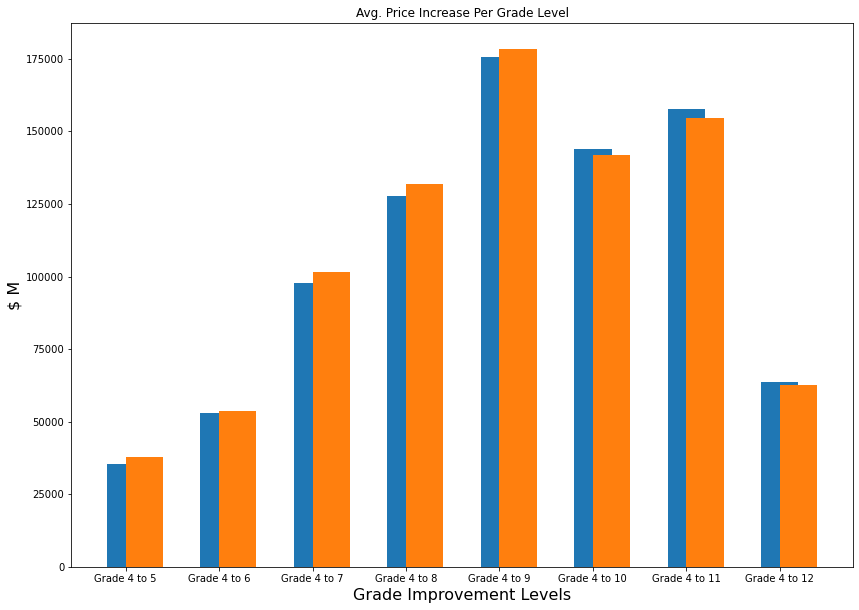

In [86]:
# graph for powerpoint
ax = plt.figure(figsize=(14, 10))
X = profit_lower.keys()
Ygirls = profit_lower.values()
Zboys = profit_upper.values()

X_axis = np.arange(len(X))

plt.bar(X_axis , Ygirls, 0.4, label = 'Lower Bound')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Upper Bound')
plt.xticks(X_axis, X)
plt.xlabel('Grade Improvement Levels', fontsize= 16)
plt.ylabel('$ M', fontsize= 16)
plt.title('Avg. Price Increase Per Grade Level')
